<a href="https://colab.research.google.com/github/sangchoi93/data_minor/blob/knn/knnProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [222]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import matplotlib.pyplot as plt


**Using sklearn to build K nearest neighbor classification**

**Reading dataset**

In [223]:
df=pd.read_csv('heart_failure_clinical_records_dataset.csv')
df['DEATH_EVENT'].value_counts()

0    203
1     96
Name: DEATH_EVENT, dtype: int64

In [224]:
df.columns

Index(['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes',
       'ejection_fraction', 'high_blood_pressure', 'platelets',
       'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'time',
       'DEATH_EVENT'],
      dtype='object')

**Selecting features and class**

In [225]:
X = df[['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes',
       'ejection_fraction', 'high_blood_pressure', 'platelets',
       'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'time']].values
X[0:5]

array([[7.5000000e+01, 0.0000000e+00, 5.8200000e+02, 0.0000000e+00,
        2.0000000e+01, 1.0000000e+00, 2.6500000e+05, 1.9000000e+00,
        1.3000000e+02, 1.0000000e+00, 0.0000000e+00, 4.0000000e+00],
       [5.5000000e+01, 0.0000000e+00, 7.8610000e+03, 0.0000000e+00,
        3.8000000e+01, 0.0000000e+00, 2.6335803e+05, 1.1000000e+00,
        1.3600000e+02, 1.0000000e+00, 0.0000000e+00, 6.0000000e+00],
       [6.5000000e+01, 0.0000000e+00, 1.4600000e+02, 0.0000000e+00,
        2.0000000e+01, 0.0000000e+00, 1.6200000e+05, 1.3000000e+00,
        1.2900000e+02, 1.0000000e+00, 1.0000000e+00, 7.0000000e+00],
       [5.0000000e+01, 1.0000000e+00, 1.1100000e+02, 0.0000000e+00,
        2.0000000e+01, 0.0000000e+00, 2.1000000e+05, 1.9000000e+00,
        1.3700000e+02, 1.0000000e+00, 0.0000000e+00, 7.0000000e+00],
       [6.5000000e+01, 1.0000000e+00, 1.6000000e+02, 1.0000000e+00,
        2.0000000e+01, 0.0000000e+00, 3.2700000e+05, 2.7000000e+00,
        1.1600000e+02, 0.0000000e+00, 0.0000

In [226]:
y = df['DEATH_EVENT'].values
y[0:5]

array([1, 1, 1, 1, 1])

**Scaling data**

In [227]:
X = preprocessing.StandardScaler().fit(X).transform(X.astype(float))
X[0:5]

array([[ 1.19294523e+00, -8.71104775e-01,  1.65728387e-04,
        -8.47579380e-01, -1.53055953e+00,  1.35927151e+00,
         1.68164843e-02,  4.90056987e-01, -1.50403612e+00,
         7.35688190e-01, -6.87681906e-01, -1.62950241e+00],
       [-4.91279276e-01, -8.71104775e-01,  7.51463953e+00,
        -8.47579380e-01, -7.07675018e-03, -7.35688190e-01,
         7.53566018e-09, -2.84552352e-01, -1.41976151e-01,
         7.35688190e-01, -6.87681906e-01, -1.60369074e+00],
       [ 3.50832977e-01, -8.71104775e-01, -4.49938761e-01,
        -8.47579380e-01, -1.53055953e+00, -7.35688190e-01,
        -1.03807313e+00, -9.09000174e-02, -1.73104612e+00,
         7.35688190e-01,  1.45416070e+00, -1.59078490e+00],
       [-9.12335403e-01,  1.14796753e+00, -4.86071002e-01,
        -8.47579380e-01, -1.53055953e+00, -7.35688190e-01,
        -5.46474088e-01,  4.90056987e-01,  8.50338444e-02,
         7.35688190e-01, -6.87681906e-01, -1.59078490e+00],
       [ 3.50832977e-01,  1.14796753e+00, -4.3548586

**Splitting data for training and testing**

In [228]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)
print('Train set:', X_train.shape, y_train.shape)
print('Test set:', X_test.shape, y_test.shape)


Train set: (224, 12) (224,)
Test set: (75, 12) (75,)


**Looking for best k value for optimum results**

In [249]:
Ks = 50
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    
    mean_acc[n-1] = accuracy_score(y_test, yhat)

    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])
mean_acc

array([0.68      , 0.74666667, 0.76      , 0.76      , 0.78666667,
       0.78666667, 0.77333333, 0.78666667, 0.78666667, 0.78666667,
       0.8       , 0.78666667, 0.78666667, 0.77333333, 0.78666667,
       0.8       , 0.8       , 0.78666667, 0.8       , 0.78666667,
       0.78666667, 0.76      , 0.78666667, 0.78666667, 0.8       ,
       0.78666667, 0.8       , 0.8       , 0.78666667, 0.8       ,
       0.78666667, 0.8       , 0.8       , 0.77333333, 0.77333333,
       0.77333333, 0.77333333, 0.76      , 0.77333333, 0.76      ,
       0.74666667, 0.76      , 0.74666667, 0.74666667, 0.74666667,
       0.74666667, 0.74666667, 0.74666667, 0.74666667])

**Plotting accuracy curve with different k values**

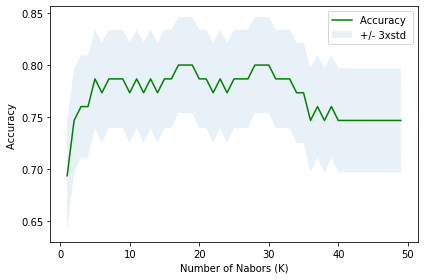

In [232]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
plt.show()

**Best k value**

In [233]:
print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

The best accuracy was with 0.8 with k= 17


**Using own calcuations to train K nearest neighbor classification model**

In [234]:
X = df.drop('DEATH_EVENT', axis=1)
y = df.DEATH_EVENT

**Minkowski algorithm with Euclidean distance**

In [235]:
def minkowski_distance(a, b, p):
    
    # Store the number of dimensions
    dim = len(a)
    
    # Set initial distance to 0
    distance = 0
    
    # Calculate minkowski distance using parameter p
    for d in range(dim):
        distance += abs(a[d] - b[d])**p
        
    distance = distance**(1/p)
    
    return distance

**Splitting training and testing data**

In [236]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

**Knn algorithm**

In [240]:
def knn_predict(X_train, X_test, y_train, y_test, k, p):
    # Counter to help with label voting
    from collections import Counter
    
    # Make predictions on the test data
    # Need output of 1 prediction per test data point
    y_hat_test = []

    for test_point in X_test:
        distances = []

        for train_point in X_train:
            distance = minkowski_distance(test_point, train_point, p=p)
            distances.append(distance)
        
        # Store distances in a dataframe
        df_dists = pd.DataFrame(data=distances, columns=['dist'], index=y_train.index)
        
        # Sort distances, and only consider the k closest points
        df_nn = df_dists.sort_values(by=['dist'], axis=0)[:k]

        # Create counter object to track the labels of k closest neighbors
        counter = Counter(y_train[df_nn.index])

        # Get most common label of all the nearest neighbors
        prediction = counter.most_common()[0][0]
        
        # Append prediction to output list
        y_hat_test.append(prediction)
        
    return y_hat_test


y_hat_test = knn_predict(X_train, X_test, y_train, y_test, k=14, p=2)
print(y_hat_test)

[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0]


In [241]:
print(accuracy_score(y_test, y_hat_test))

0.8133333333333334


**Finding best k value for Knn**

In [252]:
def find_Ks2(X_train, X_test, y_train, y_test, Ks, ps):
    mean_acc2 = np.zeros((Ks-1))
    std_acc = np.zeros((Ks-1))
    ConfustionMx = [];
    for n in range(1,Ks):
        
        #Train Model and Predict  
        yhat = knn_predict(X_train, X_test, y_train, y_test, k=n, p=2)
        mean_acc2[n-1] = accuracy_score(y_test, yhat)
        std_acc2 = np.std(mean_acc2)
    return(mean_acc2, std_acc2)
Ks = 50
ps = 2
mean_acc2, std_acc2 = find_Ks2(X_train, X_test, y_train, y_test, Ks, ps)
print(mean_acc2)
print( "The best accuracy was with", mean_acc2.max(), "with k=", mean_acc2.argmax()+1) 

[0.68       0.68       0.76       0.74666667 0.78666667 0.77333333
 0.77333333 0.78666667 0.78666667 0.8        0.8        0.8
 0.78666667 0.81333333 0.78666667 0.8        0.8        0.8
 0.8        0.8        0.78666667 0.77333333 0.78666667 0.77333333
 0.8        0.77333333 0.8        0.78666667 0.78666667 0.78666667
 0.78666667 0.78666667 0.8        0.78666667 0.77333333 0.76
 0.77333333 0.74666667 0.77333333 0.74666667 0.74666667 0.74666667
 0.74666667 0.76       0.74666667 0.74666667 0.74666667 0.74666667
 0.74666667]
The best accuracy was with 0.8133333333333334 with k= 14


**Plotting the accuracy with different k values**

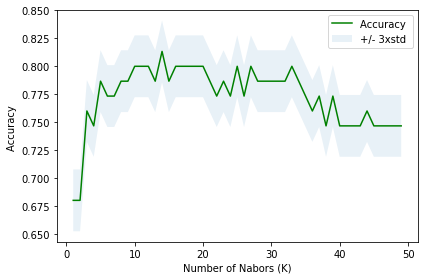

In [253]:
plt.plot(range(1,Ks),mean_acc2,'g')
plt.fill_between(range(1,Ks),mean_acc2 - 1 * std_acc2,mean_acc2 + 1 * std_acc2, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
plt.show()